In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform, loguniform
import joblib



In [11]:
# --- 1. DATA LOADING, CLEANING, AND LABELING ---

# 🔑 Loading the dataset
df = pd.read_csv("7282_1.csv", sep=',')
    
# 🔑 Data Cleaning and Preparation

# Keep only the columns we need for the sentiment analysis pipeline
df = df[['reviews.text', 'reviews.rating']].copy()


# Ensure reviews.rating is treated as numeric, coercing errors (like blank cells) to NaN
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')

In [12]:
# --- 2. BINARY LABEL DEFINITION AND FILTERING ---

# Define the binary labels:
# 0 (Negative) for ratings 1 and 2
# 1 (Positive) for ratings 4 and 5
# -1 for all others (Neutral 3-star, or NaN) to be filtered out later
df['sentiment'] = np.where(df['reviews.rating'].isin([1, 2]), 0, 
                  np.where(df['reviews.rating'].isin([4, 5]), 1, -1))

# Filter out rows that are neutral (rating 3), NaN, or non-standard
df_clean = df[df['sentiment'] != -1].copy()

print(f"Total rows in original data: {len(df)}")
print(f"Total rows used for clean baseline model (1, 2, 4, 5): {len(df_clean)}")

# Check the resulting label imbalance:
print("\n--- Cleaned Data Class Counts (0=Negative, 1=Positive) ---")
print(df_clean['sentiment'].value_counts())
print("-" * 35)


Total rows in original data: 35912
Total rows used for clean baseline model (1, 2, 4, 5): 28473

--- Cleaned Data Class Counts (0=Negative, 1=Positive) ---
sentiment
1    22426
0     6047
Name: count, dtype: int64
-----------------------------------


In [13]:

# --- 3. DEFINING FEATURES (X) AND LABELS (Y) ---
# X is the review text, y is the binary sentiment label.
#In simple terms, X contains the actual reviews written by customers, while y indicates whether those reviews are positive or negative based on the ratings given.
#"Here is the text (X), and here is the correct answer for that text (y). Go learn the relationship between them."
X = df_clean['reviews.text'] 
y = df_clean['sentiment']  

In [14]:
# --- 4. TRAIN/TEST SPLIT (70% Train, 30% Test) ---

# used stratify=y to ensure the positive/negative ratio 
# is preserved in both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("\n--- Data Split Summary ---")
print(f"Training set size: {len(X_train)} reviews")
print(f"Testing set size: {len(X_test)} reviews")

print("\nPart 1 Complete! The data is prepared.")


--- Data Split Summary ---
Training set size: 19931 reviews
Testing set size: 8542 reviews

Part 1 Complete! The data is prepared.


***NOW WE MOVE ON TO THE MODEL!!***

In [15]:
# --- 2. TF-IDF VECTORIZATION ---
print("Training TF-IDF Vectorizer...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train.astype(str))
#we use both fit and transform on the training data to learn the vocabulary and then transform (apply) the text data into numerical format.
X_test_vec = vectorizer.transform(X_test.astype(str))
#we only use transform on the test data to ensure that the test data is represented in the same feature space as the training data. the weights and vocabulary learned from the training data are applied to the test data without any changes.
print("Vectorization complete.")

Training TF-IDF Vectorizer...
Vectorization complete.


In [16]:
# --- 3. HYPERPARAMETER TUNING SETUP (Randomized Search) ---

print("\n--- 3. Starting Randomized Search for Hyperparameter Tuning ---")

# Define the parameter space for Randomized Search
param_distributions = {
    # C is the regularization parameter. Using loguniform for wide, efficient search.
    'C': loguniform(0.1, 100), 
    
    # Kernel options: 'linear' is fast and good for text, 'rbf' is more flexible.
    'kernel': ['linear', 'rbf'], 
    
    # Gamma is the kernel coefficient, relevant for 'rbf' kernel
    'gamma': ['scale', 'auto'],
}

# Initialize the SVM model with balanced weights to handle the 100:1 imbalance
# This parameter is fixed as it's essential for your project
base_svm = SVC(class_weight='balanced', random_state=42, probability=True)

# Initialize RandomizedSearchCV
# n_iter=20 means we test 20 random parameter combinations (a good balance of speed/effectiveness)
# scoring='f1' tells the search to optimize the F1-score (crucial for imbalanced data)
# cv=3 uses 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=base_svm, 
    param_distributions=param_distributions, 
    n_iter=20, 
    scoring='f1', 
    cv=3, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1  # Use all available CPU cores
)

# Fit the search to the training data
random_search.fit(X_train_vec, y_train)

print("\n--- Randomized Search Complete ---")



--- 3. Starting Randomized Search for Hyperparameter Tuning ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Randomized Search Complete ---


In [17]:
# --- 4. EVALUATION OF BEST MODEL ---

# Get the best estimator found by the search
best_svm = random_search.best_estimator_

print(f"Best F1-Score found during CV: {random_search.best_score_:.4f}")
print(f"Best Hyperparameters: {random_search.best_params_}")
print("-" * 50)

# Evaluate the final, best model on the held-out test set
y_pred_tuned = best_svm.predict(X_test_vec)

print("\n--- Final Test Set Classification Report (Tuned Model) ---")
print(classification_report(y_test, y_pred_tuned, target_names=['Negative (0)', 'Positive (1)']))

Best F1-Score found during CV: 0.9395
Best Hyperparameters: {'C': 2.334586407601624, 'gamma': 'scale', 'kernel': 'rbf'}
--------------------------------------------------

--- Final Test Set Classification Report (Tuned Model) ---
              precision    recall  f1-score   support

Negative (0)       0.80      0.75      0.77      1814
Positive (1)       0.93      0.95      0.94      6728

    accuracy                           0.91      8542
   macro avg       0.86      0.85      0.86      8542
weighted avg       0.90      0.91      0.91      8542



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# --- 1. DATA PREPARATION ---
# Note: You should replace "7282_1.csv" with your actual dataset path if different.
print("Loading and preparing data...")
try:
    df = pd.read_csv("7282_1.csv", sep=',')
except FileNotFoundError:
    print("Error: Dataset file '7282_1.csv' not found. Please check the file path.")
    exit()

df = df[['reviews.text', 'reviews.rating']].copy()
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')

# Map ratings (1, 2) to 0 (Negative) and (4, 5) to 1 (Positive)
df['sentiment'] = np.where(df['reviews.rating'].isin([1, 2]), 0, 
                  np.where(df['reviews.rating'].isin([4, 5]), 1, -1))

df_clean = df[df['sentiment'] != -1].copy()
X = df_clean['reviews.text'] 
y = df_clean['sentiment']   

# We don't strictly need a test split for feature analysis, but we maintain the best practice
X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- 2. TF-IDF VECTORIZATION ---
print("Vectorizing text data...")
# Using a common setup: 10k features, English stop words, unigrams and bigrams
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train.astype(str))


# --- 3. TRAINING LINEAR SVM (For Interpretability) ---
print("Training Linear SVC (Linear SVM) to extract feature weights...")
# Linear SVC is used specifically because its weights (coef_) are directly interpretable
svm_linear = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)
svm_linear.fit(X_train_vec, y_train)


# --- 4. EXTRACTING AND ANALYZING COEFFICIENTS ---
feature_names = vectorizer.get_feature_names_out()
coefficients = svm_linear.coef_.ravel() # Extract the weights for class 1 (Positive)

# Link the word (feature) to its influence score (coefficient)
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by coefficient magnitude
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)


# --- 5. PRINTING TOP POSITIVE AND NEGATIVE FEATURES ---

print("\n" + "="*80)
print("TOP 20 POSITIVE FEATURES (Words strongly predicting a GOOD review [1])")
print("="*80)
# Highest coefficients
print(coef_df_sorted.head(20).to_markdown(index=False))

print("\n" + "="*80)
print("TOP 20 NEGATIVE FEATURES (Words strongly predicting a BAD review [0])")
print("="*80)
# Lowest coefficients (most negative scores)
print(coef_df_sorted.tail(20).to_markdown(index=False))



Loading and preparing data...
Vectorizing text data...
Training Linear SVC (Linear SVM) to extract feature weights...

TOP 20 POSITIVE FEATURES (Words strongly predicting a GOOD review [1])
| Feature           |   Coefficient |
|:------------------|--------------:|
| enjoyed           |       2.67158 |
| amazing           |       2.64493 |
| nice              |       2.62073 |
| beautiful         |       2.60919 |
| perfect           |       2.50747 |
| complaint         |       2.43598 |
| wonderful         |       2.36443 |
| loved             |       2.35967 |
| bien              |       2.09936 |
| stay great        |       2.05519 |
| comfortable       |       2.04675 |
| clean comfortable |       2.01441 |
| comfy             |       2.01339 |
| channels          |       2.01159 |
| helpful           |       1.98456 |
| good stay         |       1.91884 |
| surprised         |       1.91876 |
| easy              |       1.89615 |
| spacious          |       1.88565 |
| french    

***Chi-Square for Location Hypothesis***

*We will use the Chi-Squared ($\chi^2$) Test to see if the proportion of positive and negative reviews is statistically dependent on the state where the hotel is located.*

In [14]:

from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# --- Configuration ---
ALPHA = 0.05
DATA_FILE = '7282_1.csv'
LOCATION_COLUMN = 'province'
RATING_COLUMN = 'reviews.rating'

# --- Hypothesis Setup ---
# H0 (Null): Province and Review Sentiment are independent.
# Ha (Alternative): Province and Review Sentiment are dependent.

def run_chi_squared_test():
    """
    Loads data, prepares the binary sentiment variable, and performs the Chi-Squared Test 
    to assess the independence between hotel location (province) and perceived quality.
    """
    print(f"--- Running Chi-Squared Test: {LOCATION_COLUMN} vs. Binary Sentiment ---")

    pd.set_option('display.max_rows', None)
    # 1. Load the dataset (Assuming file is correctly located)
    df = pd.read_csv(DATA_FILE)

    # 2. Data Preparation: Create the Binary Sentiment Score (0 or 1)
    # Filtering out rows with missing ratings, then assigning 1 (Positive) for rating >= 4 and <= 5, and 0 otherwise.
    df = df.dropna(subset=[RATING_COLUMN])
    df['Binary_Sentiment'] = np.where((df[RATING_COLUMN] >= 4) & (df[RATING_COLUMN] <= 5), 1, 0)
    print(f"Using {len(df)} records for analysis after handling missing ratings.")
    
    # 3. Create the Contingency Table (Observed Counts)
    contingency_table = pd.crosstab(df[LOCATION_COLUMN], df['Binary_Sentiment'])

    print("\n--- Contingency Table (Observed Counts) ---")
    print(contingency_table)

    # 4. Run the Chi-Squared Test
    # The result variables: chi2 statistic, p-value, degrees of freedom, expected frequencies
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print("\n==============================================")
    print("        CHI-SQUARED TEST RESULTS              ")
    print("==============================================")
    print(f"Chi2 Statistic: {chi2:.4f}")
    print(f"P-Value:        {p:.4e}")
    print(f"Degrees of Freedom: {dof}")
    print("----------------------------------------------")
    
    # 5. Interpretation
    print("Conclusion:")
    if p < ALPHA:
        print(f"P-Value ({p:.4e}) < Alpha ({ALPHA}). We **REJECT** the Null Hypothesis.")
        print("This confirms a **statistically significant dependency** between the hotel's province and its review sentiment.")
    else:
        print(f"P-Value ({p:.4e}) >= Alpha ({ALPHA}). We **FAIL TO REJECT** the Null Hypothesis.")
        print("We do not have enough evidence to conclude that province statistically affects review sentiment.")

    # Display Expected Counts for context
    expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
    expected_df.columns = ['Expected 0 (Negative)', 'Expected 1 (Positive)']
    expected_df.index.name = LOCATION_COLUMN
    print("\n--- Expected Counts (If Province and Sentiment were Independent) ---")
    print(expected_df.round(1))

if __name__ == "__main__":
    # Ensure all necessary variables and imports are executed
    run_chi_squared_test()

--- Running Chi-Squared Test: province vs. Binary Sentiment ---
Using 35050 records for analysis after handling missing ratings.

--- Contingency Table (Observed Counts) ---
Binary_Sentiment                 0     1
province                                
AK                               4    42
AL                             101   266
AR                             100   256
AZ                             101   182
Andyville                       13    23
Atl                             30    53
Baker                            4     7
Barrontown                       3     8
Bateman                          1     0
Bellefountain                    3    16
Berwyn                           2     0
Blng Spg Lks                    16    45
Bloomingville                    1     0
Blue Springs                     3     1
Boggsville                      24    45
Boston Run                       1     0
Brevik                           1     6
Brownsville                     44    48
Bull C

Analysis complete. Global Positive Review Ratio (PRR): 64.34%. Generating 4 visualization charts...


C:\Users\souma\AppData\Local\Temp\ipykernel_23244\1499598281.py:591: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y=metric, data=df_plot.reset_index(), palette=color_palette)


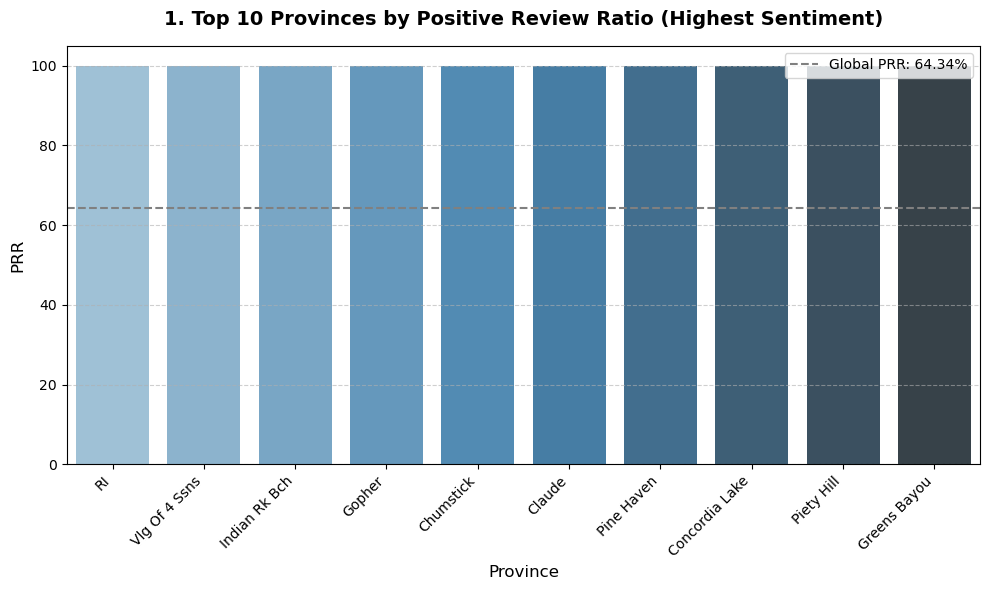

C:\Users\souma\AppData\Local\Temp\ipykernel_23244\1499598281.py:591: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y=metric, data=df_plot.reset_index(), palette=color_palette)


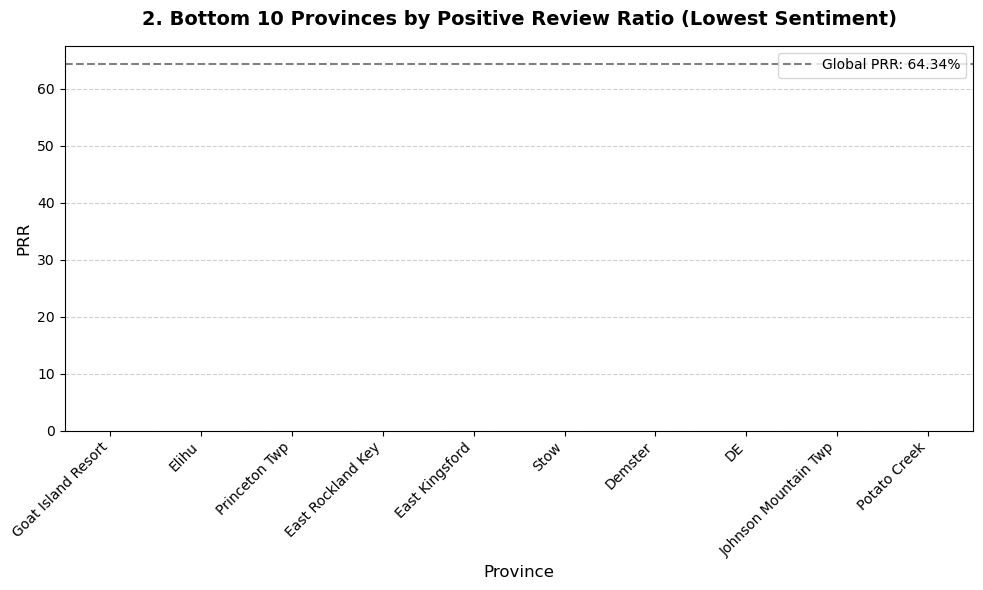

C:\Users\souma\AppData\Local\Temp\ipykernel_23244\1499598281.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y=metric, data=df_plot.reset_index(), palette=colors)


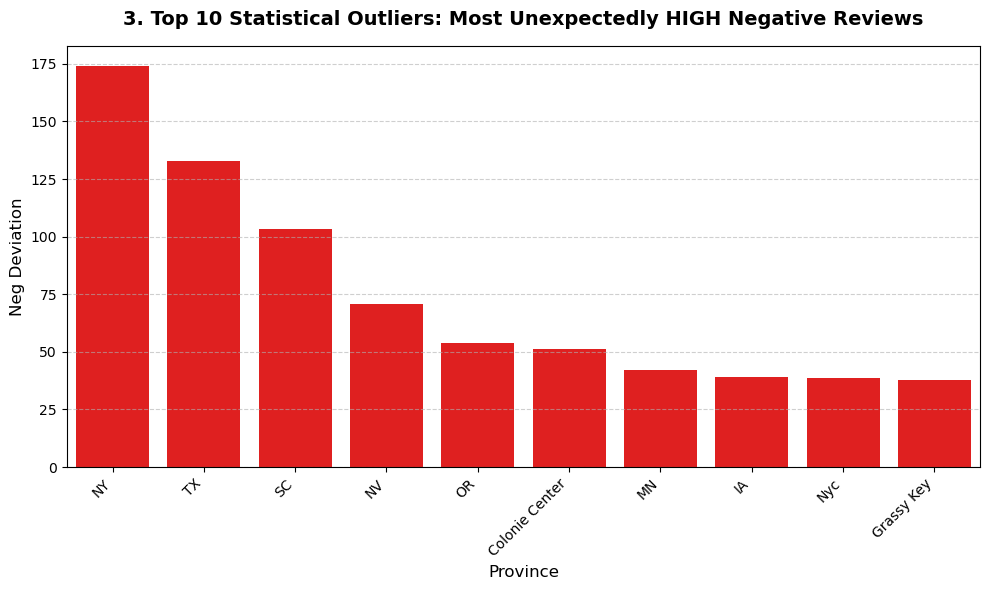

C:\Users\souma\AppData\Local\Temp\ipykernel_23244\1499598281.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_plot.index, y=metric, data=df_plot.reset_index(), palette=colors)


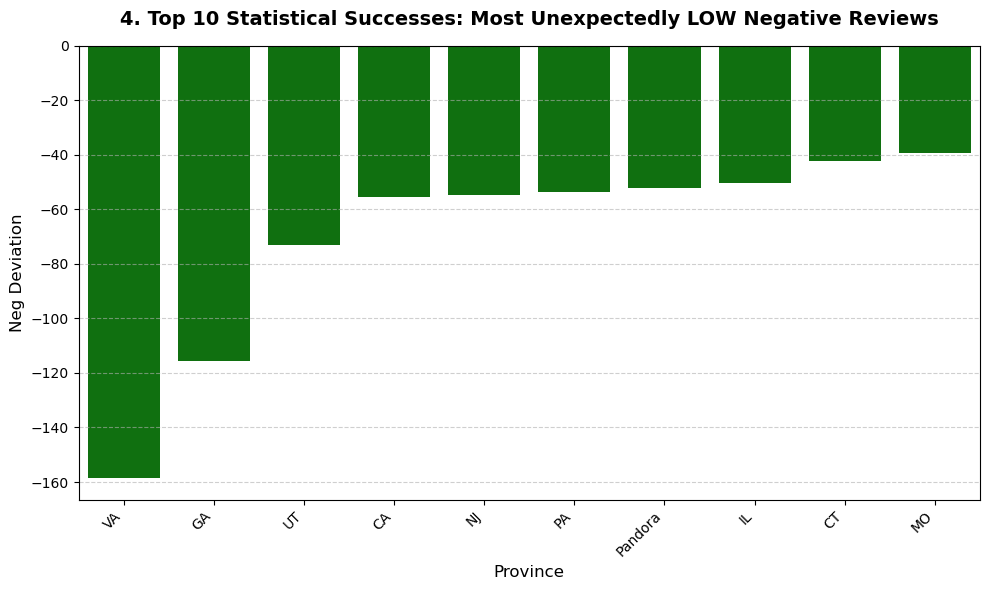


All plots are generated.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np

# --- 1. RAW DATA (Required for analysis) ---

# Observed Counts: [Province, Negative Reviews (0), Positive Reviews (1)]
# NOTE: The full, large data block is included here for the code to run standalone.
RAW_OBSERVED_DATA = """
province                                
                                        
AK                               4    42
AL                             101   266
AR                             100   256
AZ                             101   182
Andyville                       13    23
Atl                             30    53
Baker                            4     7
Barrontown                       3     8
Bateman                          1     0
Bellefountain                    3    16
Berwyn                           2     0
Blng Spg Lks                    16    45
Bloomingville                    1     0
Blue Springs                     3     1
Boggsville                      24    45
Boston Run                       1     0
Brevik                           1     6
Brownsville                     44    48
Bull Creek Village              46   148
Bunker Hill                      6    17
Bunker Hill Village              5    59
Burl                            12    76
Burr Oak                         1     0
CA                            1307  2514
CO                             276   565
CT                              26   165
Calhoun                          1     0
Camp Ground                      0    10
Canning                          2     6
Canoe Camp                       2     0
Carmel                          11    23
Carson Colony                   50    14
Chalfant Vly                     1     0
Chapmantown                     51    10
Cherry Grove                    12    78
Choconut Center                 12    51
Chumstick                        0     1
Claude                           0     1
Clearwater Lk                    1     0
Co Spgs                         15    92
Collier Twp                      1     0
Colonie Center                  91    20
Concord Farragut                71    30
Concordia Lake                   0     2
Copper Queen                     2    56
Cottonwood Station              22    54
Covell                           6    44
Cumberland                       1     0
Currie                          15     6
Cushing                         56    18
Cutler Ridge                    30    39
DC                               6    13
DE                               3     0
Dardenne Prairie                23    24
Demster                          2     0
Dieringer                        2     8
East Kingsford                   1     0
East Rockland Key                1     0
Ela                              1     1
Elihu                            2     0
Elkhurst                        40    41
Estes                            1     0
Eulalia                          2     0
Evans                            4     8
FL                             472   927
Fairhaven                        1     0
Fairholm                         2    11
Fairview Hts                     5     7
Flournoy                         3     0
Foley                            1     0
Fort Lewis                       1    11
Franklin Twp                     1     0
G P O                           10     1
G T Airport                      1     9
GA                             318   898
Galilee                         13    18
Galloway Township               52    14
Georgetown                       0    10
Giese                            4     6
Glendale                         1     0
Gloucester City                 36    21
Goat Island Resort               3     0
Gopher                           0     2
Grassy Key                      74    28
Gray                             1     0
Greens Bayou                     0     8
Greenwood Vlg                    1     0
HI                              42    84
Hanes                           11     9
Hawthorne                        3     8
Haywood                          8    21
Heglar                           4     7
Hermosa                         51    25
Hersman                          1     0
Hessdale                         2     0
Hicks Crossroads                13    54
Hisega                           3     1
Hollywood                        3    21
Hollywood Heights                1     0
Hono                            11    10
Htfd                            23    53
Hutton                           7     5
IA                             243   306
ID                              19   115
IL                             167   419
IN                             126   216
Indian Rk Bch                    0    11
Inglenook                       19     2
Jackson Hole                    19    53
Jefferson Park                  32    41
Johnson Mountain Twp             2     0
KS                              40    40
KY                              63   202
Kramer                          18    19
LA                             223   444
La Selva Beach                   9     2
Lake Clarke                      1     0
Lake Colby                       1    11
Lake Eufaula                     4    15
Lake Mary                        1     0
Lakeway                         18   104
Lakewood                        14    39
Lang Twp                         4    11
Lardo                            3    23
Lauderdale By The Sea            0     2
Lco Commercial Cent              1     0
Lindbergh                        7     9
Lk Lotawana                     34    18
Loch Raven                       1     0
Lorenzo                          1     0
Los Ranchos De Albuquerque       2     3
Lull                            19    62
Lynwood                          1     0
MA                             246   365
MD                             104   231
ME                             138   242
MI                             286   638
MN                             208   215
MO                             115   280
MS                             147   307
MT                             138   189
Manor Ridge                     11    13
Mar Vista                        1     0
Matoaca                          0     1
Meeham                          46    55
Middle Bass                     33    56
Midval                          11    46
Mist                             5    48
Morris                           1     0
Mphs                            47    61
Mystic                           2     0
N Conway                        10     7
N Egremont                       1    11
N Richland Hills                17     8
NC                             142   246
ND                              10     4
NE                              60    88
NH                               8    94
NJ                              39   221
NM                              23    61
NV                             254   226
NY                             654   574
Niwot                           23    13
Norfolk                          2     0
North Fork                      50    46
Nyc                            123   107
OH                             238   445
OK                              77   170
OR                             268   286
Okaloosa Island                  1     0
Onigum                           7    73
Orange Grove                    38    25
Ordway                           2     0
Oreana                           2     8
Orenco                           9    45
PA                             311   741
PR                              10    45
Palm Springs Municipal Airpo     2     0
Pandora                         39   208
Paradise Park                   41    30
Pawleys Isl                     13     0
Peoria                           9    18
Peytonsville                    67    60
Piety Hill                       0    22
Pine Cliff                       9    58
Pine Haven                       0    10
Pine Knoll Shores               44    57
Pitt                            34    47
Pittsburg                       34    50
Plantation                     109   132
Ponderosa                       23    72
Pontotoc                         4     8
Port Everglades                  2     1
Potato Creek                     1     0
Presidio Of Monterey            60    81
Princeton Twp                    2     0
RI                               0     1
Rehoboth                         2     0
Rockaway Bch                     1     0
Rocket Center                    1     0
Roubaix                          5    23
Round Knob                      43    47
SC                             329   283
SD                              68    69
Santa Catalina                   1     0
Scanlon                          8    12
Schoeneck                        2     5
Seabrook                        30    39
Sisquoc                          2     0
Smc                              1    19
So Effingham                     1     0
South Bowie                      1     0
South Mountain                   1     0
Southwest Ranches               11    77
Spfld                           17    40
Star City                        6    20
Stony Battery                    1     0
Stow                             3     0
Sumach                           1     0
Summit Park                      2    10
Sylvania Twp                     3     0
TN                             178   399
TX                             826   972
Timbercrk Cyn                   19     2
Toolesboro                       1     0
Treetops                         1     0
Trophy Club                      8    43
Tuftonboro                       4    17
Tuscon                          29   155
Tuttle                           9     4
UT                              25   230
Upper Holland                    4     7
VA                             794  1979
Vashon Island                    1     0
Veazie                          25    30
Venetian Islands                16    86
Vlg Of 4 Ssns                    0    21
WA                             188   363
WI                             131   338
WV                               9    12
WY                              80    53
Weirs Beach                      1     0
West Ocean City                  1    12
West Vail                        3     0
Westminster                     31    20
Whately                          1     0
White Oak                       38    42
Whiteville                       1     0
Wickford                         1     0
Willet                          51    13
Wingate                          0    48
Wm Penn Anx W                    5     5
Wmsbg                            3     8
Woodbury                        13    46
Yarmouth                       104   228
"""

# Expected Counts: [Province, Expected Negative (0), Expected Positive (1)]
RAW_EXPECTED_DATA = """
province                                
                                              
AK                                             16.4                   29.6
AL                                            130.9                  236.1
AR                                            127.0                  229.0
AZ                                            100.9                  182.1
Andyville                                      12.8                   23.2
Atl                                            29.6                   53.4
Baker                                           3.9                    7.1
Barrontown                                      3.9                    7.1
Bateman                                         0.4                    0.6
Bellefountain                                   6.8                   12.2
Berwyn                                          0.7                    1.3
Blng Spg Lks                                   21.8                   39.2
Bloomingville                                   0.4                    0.6
Blue Springs                                    1.4                    2.6
Boggsville                                     24.6                   44.4
Boston Run                                      0.4                    0.6
Brevik                                          2.5                    4.5
Brownsville                                    32.8                   59.2
Bull Creek Village                             69.2                  124.8
Bunker Hill                                     8.2                   14.8
Bunker Hill Village                            22.8                   41.2
Burl                                           31.4                   56.6
Burr Oak                                        0.4                    0.6
CA                                           1362.6                 2458.4
CO                                            299.9                  541.1
CT                                             68.1                  122.9
Calhoun                                         0.4                    0.6
Camp Ground                                     3.6                    6.4
Canning                                         2.9                    5.1
Canoe Camp                                      0.7                    1.3
Carmel                                         12.1                   21.9
Carson Colony                                  22.8                   41.2
Chalfant Vly                                    0.4                    0.6
Chapmantown                                    21.8                   39.2
Cherry Grove                                   32.1                   57.9
Choconut Center                                22.5                   40.5
Chumstick                                       0.4                    0.6
Claude                                          0.4                    0.6
Clearwater Lk                                   0.4                    0.6
Co Spgs                                        38.2                   68.8
Collier Twp                                     0.4                    0.6
Colonie Center                                 39.6                   71.4
Concord Farragut                               36.0                   65.0
Concordia Lake                                  0.7                    1.3
Copper Queen                                   20.7                   37.3
Cottonwood Station                             27.1                   48.9
Covell                                         17.8                   32.2
Cumberland                                      0.4                    0.6
Currie                                          7.5                   13.5
Cushing                                        26.4                   47.6
Cutler Ridge                                   24.6                   44.4
DC                                              6.8                   12.2
DE                                              1.1                    1.9
Dardenne Prairie                               16.8                   30.2
Demster                                         0.7                    1.3
Dieringer                                       3.6                    6.4
East Kingsford                                  0.4                    0.6
East Rockland Key                               0.4                    0.6
Ela                                             0.7                    1.3
Elihu                                           0.7                    1.3
Elkhurst                                       28.9                   52.1
Estes                                           0.4                    0.6
Eulalia                                         0.7                    1.3
Evans                                           4.3                    7.7
FL                                            498.9                  900.1
Fairhaven                                       0.4                    0.6
Fairholm                                        4.6                    8.4
Fairview Hts                                    4.3                    7.7
Flournoy                                        1.1                    1.9
Foley                                           0.4                    0.6
Fort Lewis                                      4.3                    7.7
Franklin Twp                                    0.4                    0.6
G P O                                           3.9                    7.1
G T Airport                                     3.6                    6.4
GA                                            433.6                  782.4
Galilee                                        11.1                   19.9
Galloway Township                              23.5                   42.5
Georgetown                                      3.6                    6.4
Giese                                           3.6                    6.4
Glendale                                        0.4                    0.6
Gloucester City                                20.3                   36.7
Goat Island Resort                              1.1                    1.9
Gopher                                          0.7                    1.3
Grassy Key                                     36.4                   65.6
Gray                                            0.4                    0.6
Greens Bayou                                    2.9                    5.1
Greenwood Vlg                                   0.4                    0.6
HI                                             44.9                   81.1
Hanes                                           7.1                   12.9
Hawthorne                                       3.9                    7.1
Haywood                                        10.3                   18.7
Heglar                                          3.9                    7.1
Hermosa                                        27.1                   48.9
Hersman                                         0.4                    0.6
Hessdale                                        0.7                    1.3
Hicks Crossroads                               23.9                   43.1
Hisega                                          1.4                    2.6
Hollywood                                       8.6                   15.4
Hollywood Heights                               0.4                    0.6
Hono                                            7.5                   13.5
Htfd                                           28.9                   52.1
Hutton                                          4.3                    7.7
IA                                            203.9                  367.1
ID                                             50.7                   91.3
IL                                            217.4                  392.6
IN                                            131.7                  237.3
Indian Rk Bch                                   3.9                    7.1
Inglenook                                       7.5                   13.5
Jackson Hole                                   25.3                   45.7
Jefferson Park                                 27.4                   49.6
Johnson Mountain Twp                            0.7                    1.3
KS                                             31.4                   56.6
KY                                             90.0                  162.0
Kramer                                         14.4                   26.6
LA                                            246.7                  445.3
La Selva Beach                                  4.3                    7.7
Lake Clarke                                     0.4                    0.6
Lake Colby                                      4.3                    7.7
Lake Eufaula                                    7.1                    12.9
Lake Mary                                       0.4                    0.6
Lakeway                                        45.3                   81.7
Lakewood                                       19.9                   36.1
Lang Twp                                        5.4                    9.6
Lardo                                           9.3                    16.7
Lauderdale By The Sea                           0.7                    1.3
Lco Commercial Cent                             0.4                    0.6
Lindbergh                                       6.1                    10.9
Lk Lotawana                                    19.2                   34.8
Loch Raven                                      0.4                    0.6
Lorenzo                                         0.4                    0.6
Los Ranchos De Albuquerque                      1.8                    3.2
Lull                                           28.5                   51.5
Lynwood                                         0.4                    0.6
MA                                            236.2                  425.8
MD                                            127.4                  229.6
ME                                            147.2                  265.8
MI                                            301.9                  544.1
MN                                            165.7                  299.3
MO                                            154.4                  277.6
MS                                            169.3                  304.7
MT                                            124.9                  225.1
Manor Ridge                                     9.3                    16.7
Mar Vista                                       0.4                    0.6
Matoaca                                         0.4                    0.6
Meeham                                         36.4                   65.6
Middle Bass                                    33.1                   59.9
Midval                                         20.3                   36.7
Mist                                           19.2                   34.8
Morris                                          0.4                    0.6
Mphs                                           42.2                   75.8
Mystic                                          0.7                    1.3
N Conway                                        6.4                    10.6
N Egremont                                      4.3                    7.7
N Richland Hills                                9.6                    16.4
NC                                            135.0                  243.0
ND                                              5.4                    9.6
NE                                             57.6                  103.4
NH                                             36.7                   66.3
NJ                                            93.9                  169.1
NM                                             30.0                   54.0
NV                                            183.1                  330.9
NY                                            479.9                  866.1
Niwot                                          13.7                   24.3
Norfolk                                         0.7                    1.3
North Fork                                     35.6                   64.4
Nyc                                            84.2                  151.8
OH                                            236.9                  427.1
OK                                             86.3                  155.7
OR                                            214.3                  386.7
Okaloosa Island                                 0.4                    0.6
Onigum                                         28.5                   51.5
Orange Grove                                   22.8                   41.2
Ordway                                          0.7                    1.3
Oreana                                          3.6                    6.4
Orenco                                         19.2                   34.8
PA                                            364.6                  657.4
PR                                             19.6                   35.4
Palm Springs Municipal Airpo                    0.7                    1.3
Pandora                                        91.0                  163.0
Paradise Park                                  25.3                   45.7
Pawleys Isl                                     4.6                    7.7
Peoria                                          9.3                    16.7
Peytonsville                                   49.6                   89.4
Piety Hill                                      7.9                    14.1
Pine Cliff                                     24.6                   44.4
Pine Haven                                      3.6                    6.4
Pine Knoll Shores                              36.4                   65.6
Pitt                                           30.3                   54.7
Pittsburg                                      31.4                   56.6
Plantation                                     88.1                  158.9
Ponderosa                                      34.2                   61.8
Pontotoc                                        4.3                    7.7
Port Everglades                                 1.1                    1.9
Potato Creek                                    0.4                    0.6
Presidio Of Monterey                           51.1                   91.9
Princeton Twp                                   0.7                    1.3
RI                                              0.4                    0.6
Rehoboth                                        0.7                    1.3
Rockaway Bch                                    0.4                    0.6
Rocket Center                                   0.4                    0.6
Roubaix                                        10.3                   18.7
Round Knob                                     33.5                   60.5
SC                                            225.8                  406.2
SD                                             53.9                   97.1
Santa Catalina                                  0.4                    0.6
Scanlon                                         7.1                    12.9
Schoeneck                                       2.5                    4.5
Seabrook                                       24.6                   44.4
Sisquoc                                         0.7                    1.3
Smc                                             7.1                    12.9
So Effingham                                    0.4                    0.6
South Bowie                                     0.4                    0.6
South Mountain                                  0.4                    0.6
Southwest Ranches                              31.4                   56.6
Spfld                                          21.8                   39.2
Star City                                       9.3                    16.7
Stony Battery                                   0.4                    0.6
Stow                                            1.1                    1.9
Sumach                                          0.4                    0.6
Summit Park                                     4.3                    7.7
Sylvania Twp                                    1.8                    3.2
TN                                            203.2                  365.8
TX                                            693.3                 1251.7
Timbercrk Cyn                                   7.9                    14.1
Toolesboro                                      0.4                    0.6
Treetops                                        0.4                    0.6
Trophy Club                                    18.9                   34.1
Tuftonboro                                      7.9                    14.1
Tuscon                                         53.9                   97.1
Tuttle                                          5.0                    9.0
UT                                             98.2                  177.8
Upper Holland                                   4.3                    7.7
VA                                            952.5                 1719.5
Vashon Island                                   0.4                    0.6
Veazie                                         19.6                   35.4
Venetian Islands                               36.4                   65.6
Vlg Of 4 Ssns                                   7.5                    13.5
WA                                            203.9                  367.1
WI                                            165.7                  299.3
WV                                              8.2                    14.8
WY                                             52.5                   94.5
Weirs Beach                                     0.4                    0.6
West Ocean City                                 4.6                    7.7
West Vail                                       1.1                    1.9
Westminster                                    19.9                   36.1
Whately                                         0.4                    0.6
White Oak                                      29.6                   53.4
Whiteville                                      0.4                    0.6
Wickford                                        0.4                    0.6
Willet                                         23.2                   41.8
Wingate                                        17.4                   31.6
Wm Penn Anx W                                   3.6                    6.4
Wmsbg                                           3.9                    7.1
Woodbury                                       21.0                   38.0
Yarmouth                                      131.7                  237.3
"""
# --- END RAW DATA ---


def parse_data(raw_data, is_float=False):
    """Handles the messy space-separated data format into a clean DataFrame."""
    # Use StringIO to treat the string as a file
    data_io = StringIO(raw_data)
    
    # Read the data using a regex separator
    df = pd.read_csv(
        data_io, 
        sep=r'\s{2,}',          # Separator is 2 or more spaces
        engine='python', 
        skipinitialspace=True,
        header=None,           # CRITICAL: There is no header
        skiprows=2             # CRITICAL: Skip the 'province' and blank line
    )
    
    # Manually assign the column names
    df.columns = ['province', '0_reviews', '1_reviews']
    
    # Convert counts to numeric, coercing errors to NaN
    df['0_reviews'] = pd.to_numeric(df['0_reviews'], errors='coerce')
    df['1_reviews'] = pd.to_numeric(df['1_reviews'], errors='coerce')
    
    # Set index and fill NaNs that resulted from parsing
    return df.set_index('province').fillna(0)


def calculate_metrics(observed_df, expected_df):
    """Calculates PRR and Negative Deviation, the core metrics."""
    df = observed_df.rename(columns={'0_reviews': 'Obs_Neg', '1_reviews': 'Obs_Pos'})
    df['Exp_Neg'] = expected_df['0_reviews']
    
    df['Total'] = df['Obs_Neg'] + df['Obs_Pos']
    
    # Positive Review Ratio (PRR) - High PRR = Good Sentiment
    df['PRR'] = (df['Obs_Pos'] / df['Total']) * 100

    # Negative Deviation - (Observed Negative - Expected Negative)
    # This is the statistical driver of the Chi-Squared value.
    df['Neg_Deviation'] = df['Obs_Neg'] - df['Exp_Neg']
    
    # Only keep provinces with actual reviews
    return df.dropna(subset=['Total']).loc[df['Total'] > 0]

# --- 3. SIMPLIFIED PLOTTING FUNCTION ---

def create_bar_chart(data, metric, title, top_n=10, ascending=False, target_prr=None):
    """Generates a bar plot for the top N outliers based on a metric."""
    
    # Sort the data and select the top N provinces for the plot
    df_plot = data.sort_values(metric, ascending=ascending).head(top_n)
    
    plt.figure(figsize=(10, 6))
    
    # --- Dynamic Coloring and Labels ---
    if metric == 'PRR':
        # Blue for the high performers, Red for the low performers
        color_palette = 'Blues_d' if not ascending else 'Reds_d'
        sns.barplot(x=df_plot.index, y=metric, data=df_plot.reset_index(), palette=color_palette)
        
        # Add the global benchmark line
        if target_prr is not None:
            plt.axhline(target_prr, color='gray', linestyle='--', linewidth=1.5, label=f'Global PRR: {target_prr:.2f}%')
            plt.legend(loc='upper right')
            
    elif metric == 'Neg_Deviation':
        # Use Red for positive deviation (Observed Negative > Expected Negative = Bad)
        # Use Green for negative deviation (Observed Negative < Expected Negative = Good)
        colors = ['red' if d > 0 else 'green' for d in df_plot[metric]]
        sns.barplot(x=df_plot.index, y=metric, data=df_plot.reset_index(), palette=colors)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5) # Zero line for deviation
        
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Province', fontsize=12)
    plt.ylabel(metric.replace('_', ' '), fontsize=12) # Clean up y-axis label
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. EXECUTION ---

# 1. Load and Calculate Metrics
observed_df = parse_data(RAW_OBSERVED_DATA)
expected_df = parse_data(RAW_EXPECTED_DATA)
analysis_df = calculate_metrics(observed_df, expected_df)

# Calculate global context PRR
total_pos = observed_df['1_reviews'].sum()
total_reviews = observed_df['0_reviews'].sum() + total_pos
global_prr = (total_pos / total_reviews) * 100

print(f"Analysis complete. Global Positive Review Ratio (PRR): {global_prr:.2f}%. Generating 4 visualization charts...")

# 2. Generate the Four Charts using the single, simplified function

# Chart 1: Highest PRR (Best Sentiment)
create_bar_chart(
    analysis_df, 
    metric='PRR', 
    title=f'1. Top 10 Provinces by Positive Review Ratio (Highest Sentiment)', 
    ascending=False, # Highest PRR first
    target_prr=global_prr
)

# Chart 2: Lowest PRR (Worst Sentiment)
create_bar_chart(
    analysis_df, 
    metric='PRR', 
    title=f'2. Bottom 10 Provinces by Positive Review Ratio (Lowest Sentiment)', 
    ascending=True, # Lowest PRR first
    target_prr=global_prr
)

# Chart 3: Most Positive Negative Deviation (Largest Chi-Squared Drivers)
create_bar_chart(
    analysis_df, 
    metric='Neg_Deviation', 
    title='3. Top 10 Statistical Outliers: Most Unexpectedly HIGH Negative Reviews', 
    ascending=False # Highest deviation (Obs > Exp) first
)

# Chart 4: Most Negative Negative Deviation (Largest Statistical Successes)
create_bar_chart(
    analysis_df, 
    metric='Neg_Deviation', 
    title='4. Top 10 Statistical Successes: Most Unexpectedly LOW Negative Reviews', 
    ascending=True # Lowest deviation (Obs < Exp) first
)

print("\nAll plots are generated.")